# Mask R-CNN - Inspect Training Data

* 检查并可视化数据加载和预处理代码

In [6]:
# Using Tensorflow-2.4.x
import tensorflow as tf
try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass

import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# 项目根目录 E:\Mask_RCNN-tf2
ROOT_DIR = os.path.abspath("../../")

# 导入 Mask RCNN
sys.path.append(ROOT_DIR)  # 查找库的本地版本
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline

## Configurations

* 运行以下代码块之一，以导入和加载要使用的configurations

In [9]:
# 运行其中一个代码块加载配置，[Shape toy dataset] 或者 [MS COCO dataset]

# Shapes toy dataset
# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
import coco
config = coco.CocoConfig()
COCO_DIR = "./dataset"  # TODO: enter value here   这里是存放数据的相对路径
print(COCO_DIR)
# config.display()

./dataset


## Dataset

In [10]:
# 加载 dataset
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset = coco.CocoDataset()
    dataset.load_coco(COCO_DIR, "train")

# 使用数据集前必须先调用 .prepare()
dataset.prepare()

# 打印当前 COCO 数据集的图片数量，类别数量，具体类别
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=10.09s)
creating index...
index created!
Image Count: 82081
Class Count: 81
  0. BG                                                
  1. person                                            
  2. bicycle                                           
  3. car                                               
  4. motorcycle                                        
  5. airplane                                          
  6. bus                                               
  7. train                                             
  8. truck                                             
  9. boat                                              
 10. traffic light                                     
 11. fire hydrant                                      
 12. stop sign                                         
 13. parking meter                                     
 14. bench                                             
 15. bird                                

## Display Samples

* 加载并显示图像和 mask.

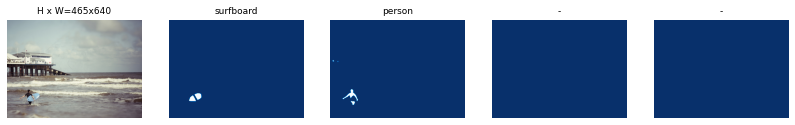

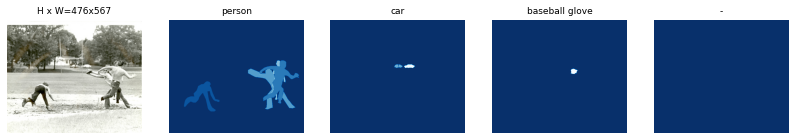

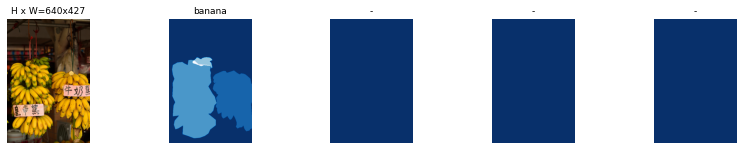

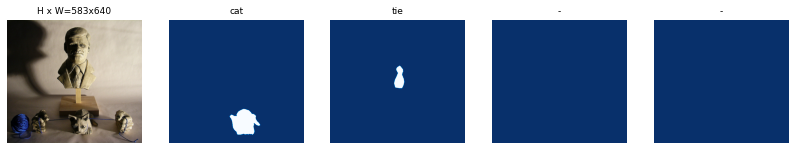

In [11]:
# 加载并显示4个随机样本
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

## Bounding Boxes
* 我们不是使用源数据集提供的边界框坐标，而是从mask计算边界框。 这使我们能够始终如一地处理边界框，而不管源数据集如何，而且还使调整图像大小，旋转或裁剪图像变得更加容易，因为我们只是从更新mask 生成边界框，而不是为每种图像类型计算边界框变换转型

image_id  80263 http://cocodataset.org/#explore?id=255714
image                    shape: (424, 640, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (424, 640, 15)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (15,)                 min:    1.00000  max:   14.00000  int32
bbox                     shape: (15, 4)               min:    0.00000  max:  493.00000  int32


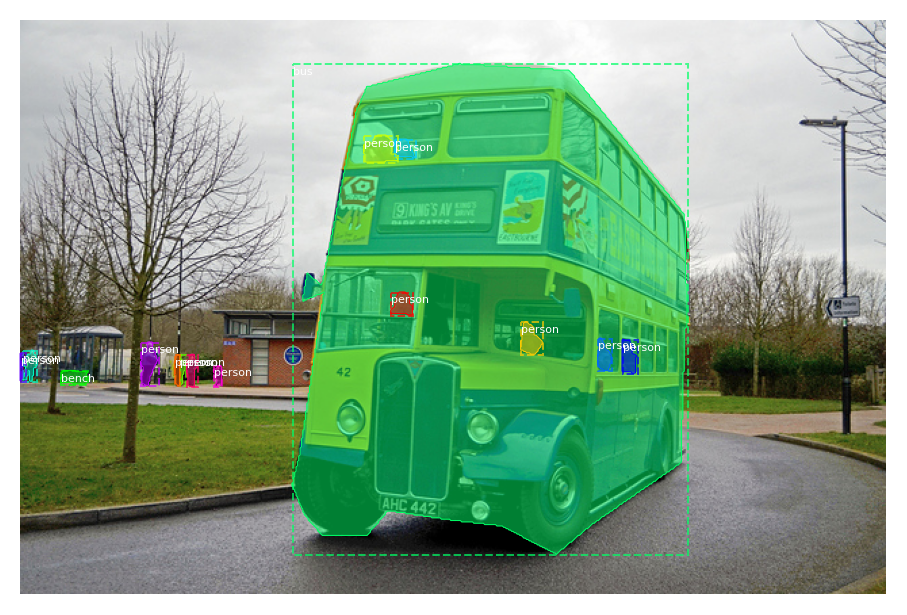

In [12]:
# 加载随机图像和 mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# 计算 Bounding box
bbox = utils.extract_bboxes(mask)

# 显示图像和其他统计数据
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# 显示图像和实例
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Resize Images
为了每批支持多张图像，将图像调整为一种尺寸（1024x1024）。 不过，长宽比会保留下来。 如果图像不是正方形，则在顶部/底部或右侧/左侧添加零填充。

image_id:  15334 http://cocodataset.org/#explore?id=560581
Original shape:  (480, 640, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1024, 1024, 6)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (6,)                  min:    1.00000  max:   10.00000  int32
bbox                     shape: (6, 4)                min:    0.00000  max: 1024.00000  int32


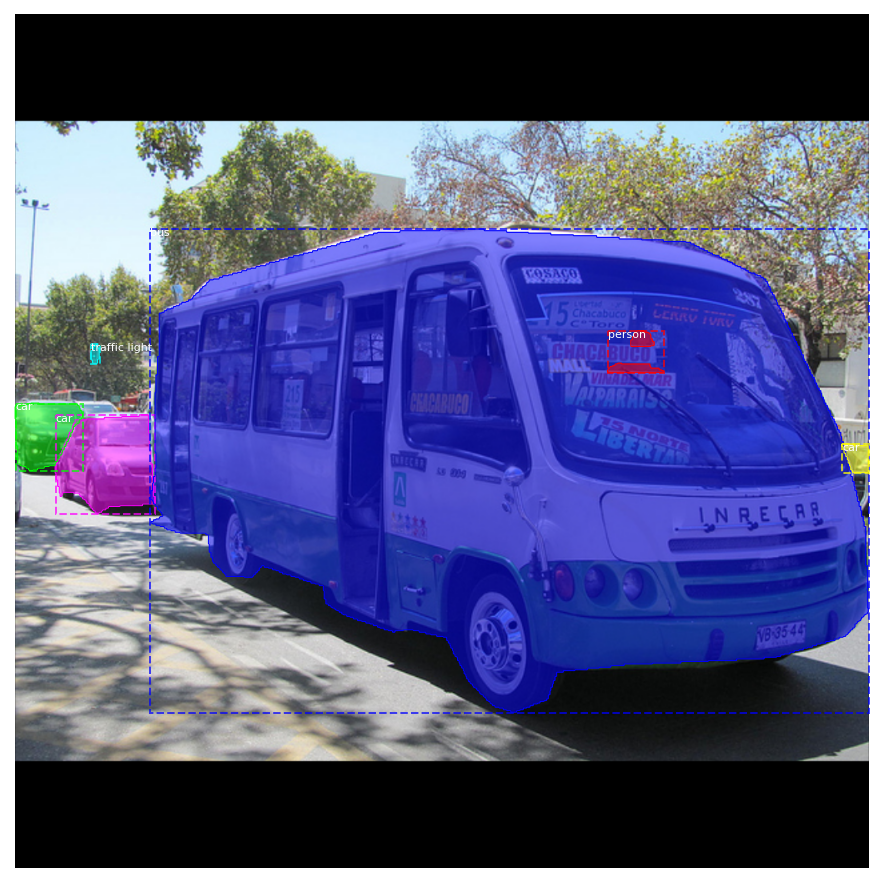

In [17]:
# 加载随机图像和蒙版.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# 计算 Bounding box
bbox = utils.extract_bboxes(mask)

# 显示图像和其他统计数据
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# 显示 图像和实例
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Mini Masks
* 使用高分辨率图像进行训练时，实例二进制掩码可能会变大。 例如，如果使用1024x1024图像进行训练，则单个实例的遮罩需要1MB的内存（Numpy使用字节作为布尔值）。 如果一个图像有100个实例，那么仅遮罩即为100MB。
为了提高训练速度，我们通过以下方法优化蒙版：
* 我们存储对象边界框内的蒙版像素，而不是完整图像的蒙版。 与图像尺寸相比，大多数对象较小，因此我们通过在对象周围不存储很多零来节省空间。
* 我们将蒙版调整为较小的尺寸（例如56x56）。 对于大于所选尺寸的物体，我们会失去一些准确性。 但是大多数对象注释一开始都不是很准确，因此对于大多数实际目的而言，这种损失可以忽略不计。 mini_mask的大小可以在config类中设置。
为了可视化掩码调整大小的效果，并验证代码的正确性，我们可视化了一些示例。

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (93,)                 min:    0.00000  max: 73336.00000  float64
class_ids                shape: (14,)                 min:    1.00000  max:   25.00000  int32
bbox                     shape: (14, 4)               min:  150.00000  max:  896.00000  int32
mask                     shape: (56, 56, 14)          min:    0.00000  max:    1.00000  bool


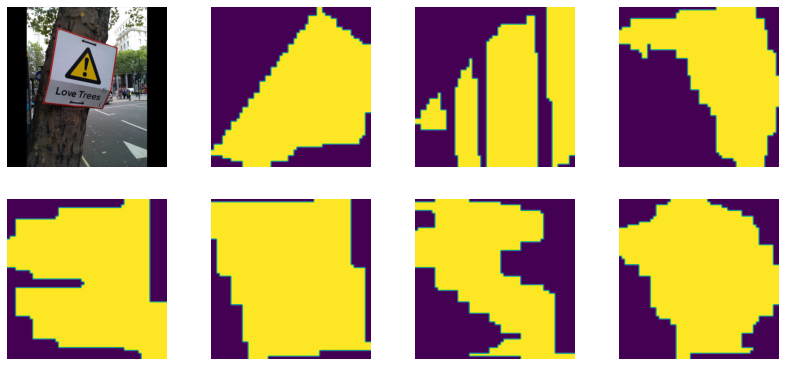

In [18]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

In [19]:
# visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 14)          min:    0.00000  max:    1.00000  bool


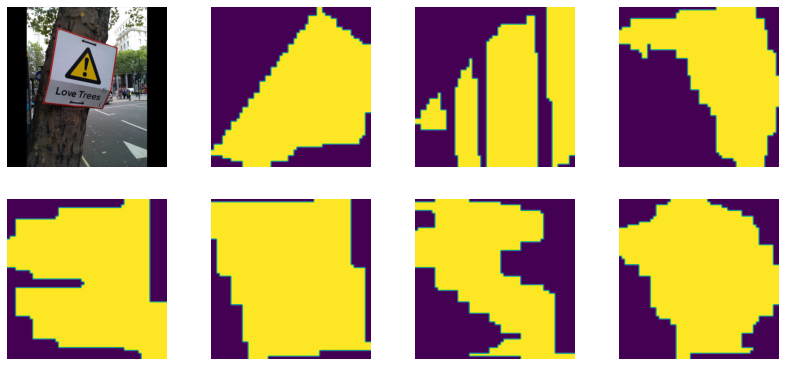

In [19]:
# 使用mini-mask,但是无法使用augment做增强
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

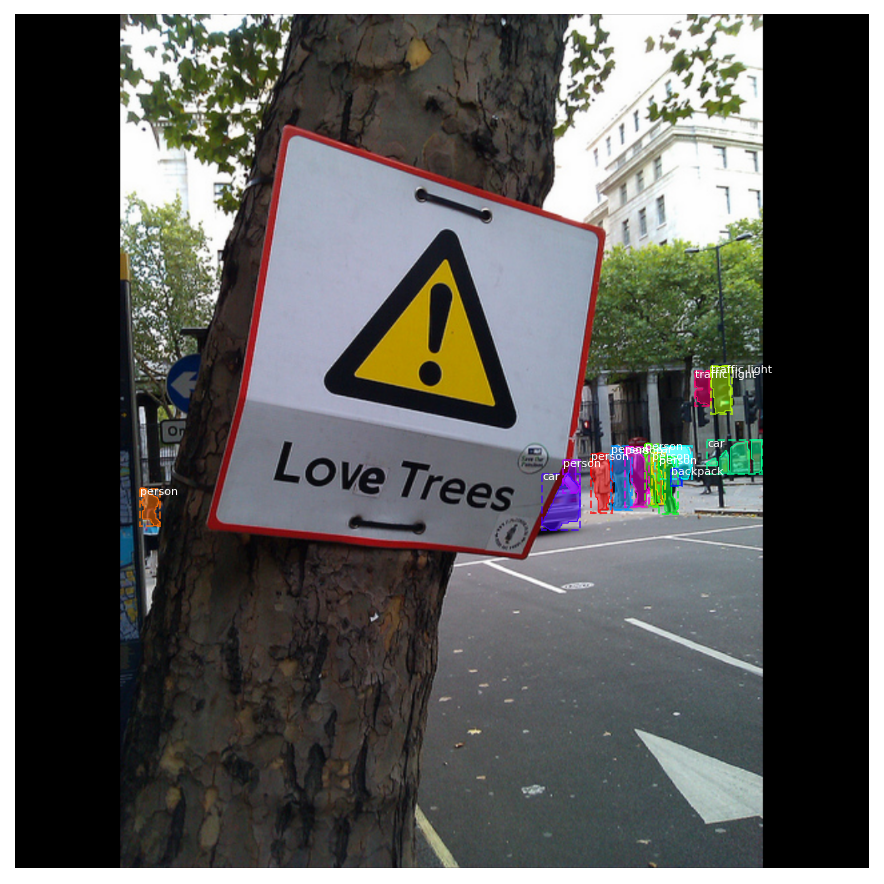

In [20]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors
* 锚点的顺序很重要。在训练和预测阶段使用相同的顺序。并且它必须匹配卷积执行的顺序。
对于FPN网络，必须对锚进行排序，以使其易于将锚与预测锚得分和移动的卷积层的输出进行匹配。
首先按金字塔等级排序。第一层的所有锚点，然后第二层的所有锚点，依此类推。这样可以更轻松地按级别分离锚点。
* 在每个级别内，按特征图处理顺序对锚点进行排序。通常，卷积层处理从左上角开始并逐行右移的特征图。
* 对于每个要素地图单元，为不同比例的锚点选择任何排序顺序。在这里，我们匹配传递给函数的比率的顺序。
* Anchor Stride：在FPN架构中，前几层的要素地图是高分辨率的。例如，如果输入图像为1024x1024，则第一层的特征图为256x256，这将生成大约200K锚点（256x256x3）。这些锚点为32x32像素，相对于图像像素的跨度为4像素，因此存在很多重叠。如果我们为特征图中的每个其他像元生成锚点，则可以显着降低负载。例如，跨度为2时，锚点数将减少4。
* 在此实现中，我们使用的锚跨距为2，这与纸张不同。

In [22]:
# 生成 Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# 打印 anchors 摘要
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (32, 64, 128, 256, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


* 在特定级别的特征图中心可视化一个单元的锚点

Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


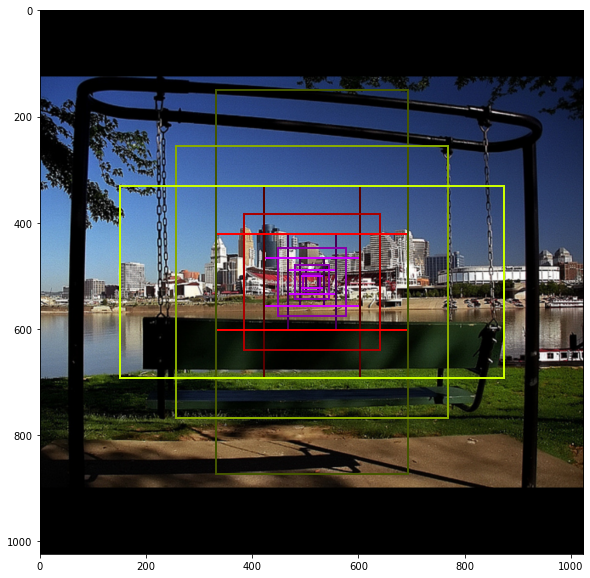

In [23]:
## 在特定级别的特征图中心可视化一个单元的锚点

# 加载和绘制随机图像
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # 计算图像中心的锚点的索引
    level_start = sum(anchors_per_level[:level]) # 之前级别的锚总和
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    # 绘制 anchors. 亮度显示阵列中的顺序，从暗到明
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator


In [24]:
# 创建数据生成器
random_rois = 2000
g = modellib.DataGenerator(
    dataset, config, shuffle=True, random_rois=random_rois,
    detection_targets=True)

In [25]:
# Uncomment to run the generator through a lot of images
# to catch rare errors
# for i in range(1000):
#     print(i)
#     _, _ = next(g)

In [26]:
# 得到下一张图像
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = g[0]
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = g[0]
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# 删除 mrcnn_class_ids 的最后一维，它只是添加用于满足keras要求的目标形状
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (1, 200, 4)           min:    2.00000  max: 1022.00000  int32
mrcnn_class_ids          shape: (1, 200, 1)           min:    0.00000  max:   61.00000  int32
mrcnn_bbox               shape: (1, 200, 81, 4)       min:   -2.40919  max:    2.92154  float32
mrcnn_mask               shape: (1, 200, 28, 28, 81)  min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (1, 100)              min:    0.00000  max:   61.00000  int32
gt_boxes                 shape: (1, 100, 4)           min:    0.00000  max: 1024.00000  int32
gt_masks                 shape: (1, 56, 56, 100)      min:    0.00000  max:    1.00000  bool
rpn_match                shape: (1, 261888, 1)        min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (1, 256, 4)           min:   -5.00000  max:    5.00000  float64
image_id:  38696 http://cocodataset.org/#explore?id=107421


anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (99, 4)               min:   -0.00000  max: 1024.00000  float32
Positive anchors: 99
Negative anchors: 157
Neutral anchors: 261632
BG                     : 168
person                 : 4
cup                    : 4
fork                   : 3
spoon                  : 3
bowl                   : 11
dining table           : 7


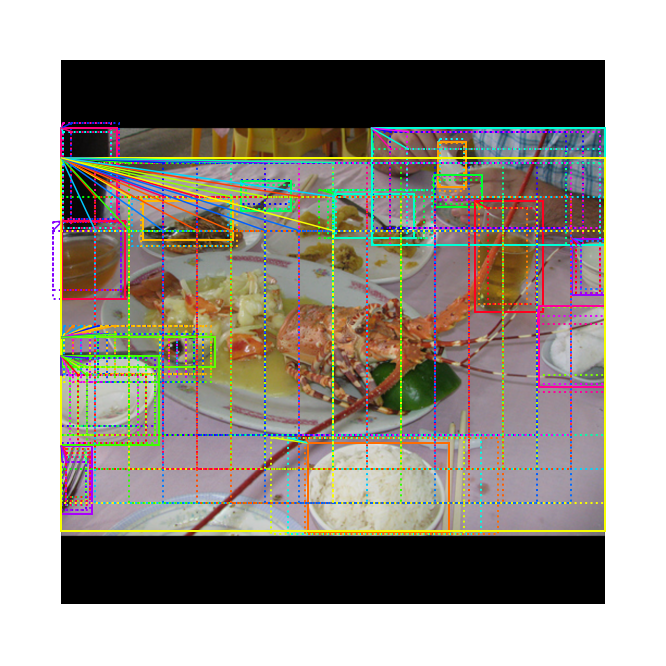

In [27]:
b = 0

# 恢复原始图像(反向标准化)
# sample_image = modellib.unmold_image(normalized_images[b], config)
sample_image = modellib.unmold_image(normalized_images[b], config)

# 计算 anchors 的偏移
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# 获取 postive anchors 的列表
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI 逐类细分
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# 显示 postive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

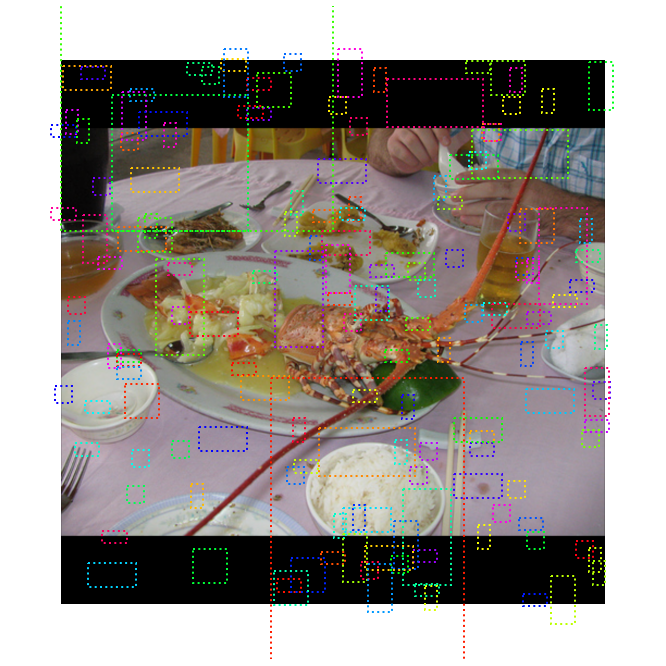

In [28]:
# 显示 negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

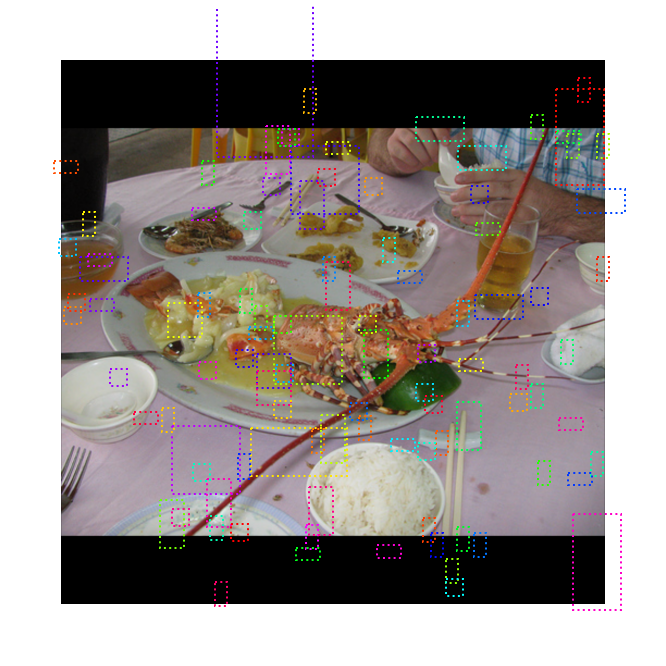

In [29]:
# 显示 neutral anchors. 他们没有促进训练
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  32
Negative ROIs:  168
Positive Ratio: 0.16
Unique ROIs: 200 out of 200


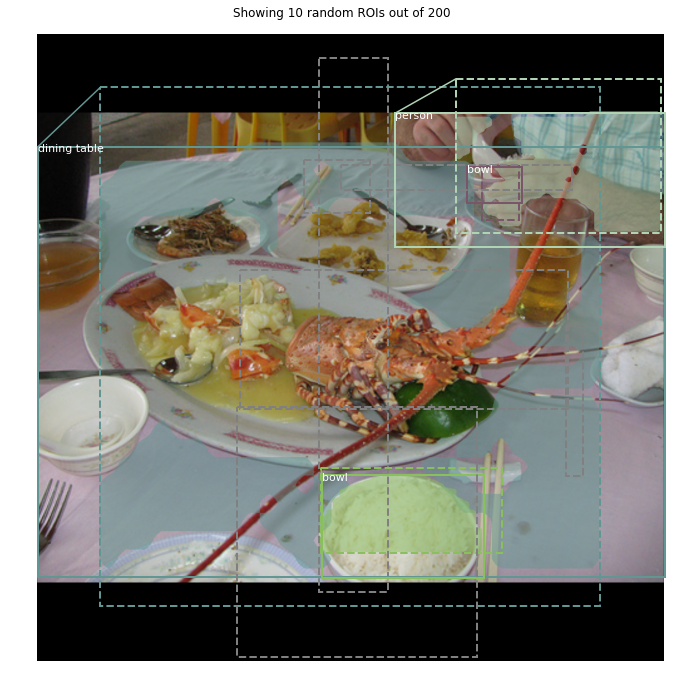

In [30]:
if random_rois:
    # 类别的 bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # 调整 ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # 类别的 masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # 任何重复的 ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

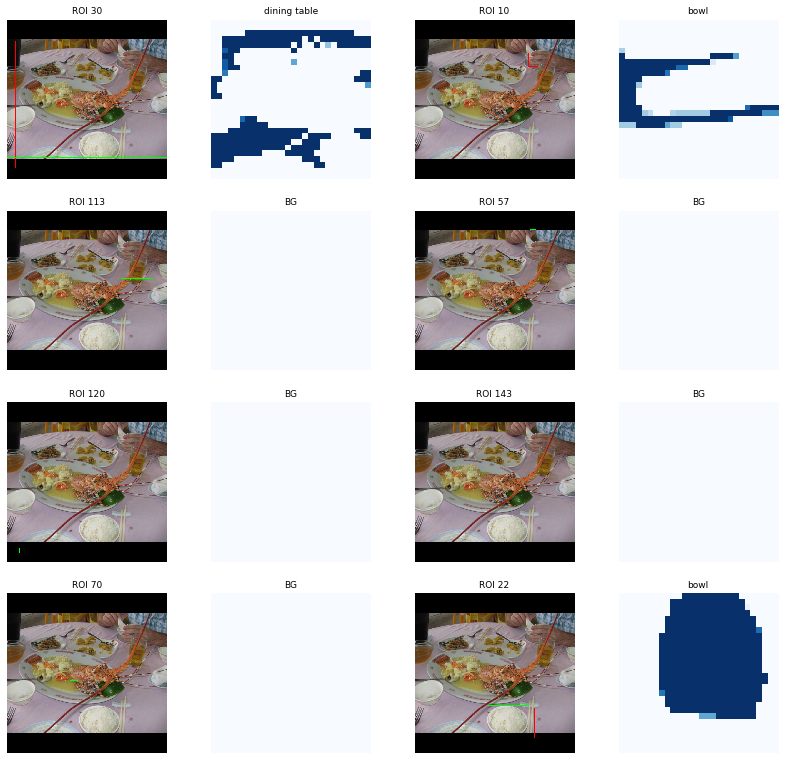

In [36]:
if random_rois:
    # 显示 ROIs 和相应的 masks, bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [38]:
# Check ratio of positive ROIs in a set of images.
# 检查一组图像中 positive ROIs 的比例
if random_rois:
    limit = 5
    temp_g = modellib.DataGenerator(
        dataset, config, shuffle=True, random_rois=10000, 
        detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = temp_g[i]
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33
